In [27]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, Activation, ZeroPadding2D, concatenate, Input, Layer
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D, AveragePooling2D
from keras.layers import Concatenate
from keras.layers import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
# from keras.engine import Layer
from keras import backend as K
K.set_image_data_format('channels_first')
import numpy as np
import cv2
import os
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from inception_block import *
import utils


In [2]:
FRmodel = faceRecoModel((3, 96, 96))
print(FRmodel.summary())

Model: "FaceRecoModel"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 96, 96) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_23   │ (None, 3, 102,    │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 102)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 64, 48,    │      9,472 │ zero_padding2d_2… │
│                     │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn1                 │ (None, 64, 48,    │        256 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 64, 48,    │          0 │ bn1[0][0]         │
│ (Activation)        │ 48)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_24   │ (None, 64, 50,    │          0 │ activation_37[0]… │
│ (ZeroPadding2D)     │ 50)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 24,    │          0 │ zero_padding2d_2… │
│ (MaxPooling2D)      │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2 (Conv2D)      │ (None, 64, 24,    │      4,160 │ max_pooling2d_6[… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn2                 │ (None, 64, 24,    │        256 │ conv2[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 64, 24,    │          0 │ bn2[0][0]         │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_25   │ (None, 64, 26,    │          0 │ activation_38[0]… │
│ (ZeroPadding2D)     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3 (Conv2D)      │ (None, 192, 24,   │    110,784 │ zero_padding2d_2… │
│                     │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn3                 │ (None, 192, 24,   │        768 │ conv3[0][0]       │
│ (BatchNormalizatio… │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_39       │ (None, 192, 24,   │          0 │ bn3[0][0]         │
│ (Activation)        │ 24)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_26   │ (None, 192, 26,   │          0 │ activation_39[0]… │
│ (ZeroPadding2D)     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 192, 12,   │          0 │ zero_padding2d_2… │
│ (MaxPooling2D)      │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_3a_3x3_c… │ (None, 96, 12,    │     18,528 │ max_pooling2d_7[

 Total params: 3,743,280 (14.28 MB)

 Trainable params: 3,733,968 (14.24 MB)

 Non-trainable params: 9,312 (36.38 KB)

None


In [3]:
def triplet_loss(y_true, y_pred, alpha = 0.2):
    """
    Implementation of the triplet loss as defined by formula (3)
    
    Arguments:
    y_true -- true labels, required when you define a loss in Keras, you don't need it in this function.
    y_pred -- python list containing three objects:
            anchor -- the encodings for the anchor images, of shape (None, 128)
            positive -- the encodings for the positive images, of shape (None, 128)
            negative -- the encodings for the negative images, of shape (None, 128)
    
    Returns:
    loss -- real number, value of the loss
    """
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
    #Compute the (encoding) distance between the anchor and the positive, sum over axis=-1
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis = -1)
    #Compute the (encoding) distance between the anchor and the negative, sum over axis=-1
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis = -1)
    #subtract the two previous distances and add alpha.
    basic_loss = pos_dist- neg_dist + alpha
    #Take the maximum of basic_loss and 0.0. Sum over the training examples.
    loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    

    return loss



In [4]:
FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
utils.load_weights_from_FaceNet(FRmodel)

In [15]:
database = {}
database["danielle"] = utils.img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = utils.img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = utils.img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = utils.img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = utils.img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = utils.img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = utils.img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = utils.img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = utils.img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = utils.img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = utils.img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = utils.img_to_encoding("images/arnaud.jpg", FRmodel)

(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)
(1, 3, 96, 96)


In [ ]:
def verify(image_path, identity, database, model):
    """
    Function that verifies if the person on the "image_path" image is "identity".
    
    Arguments:
    image_path -- path to an image
    identity -- string, name of the person you'd like to verify the identity. Has to be an employee who works in the office.
    database -- python dictionary mapping names of allowed people's names (strings) to their encodings (vectors).
    model -- your Inception model instance in Keras
    
    Returns:
    dist -- distance between the image_path and the image of "identity" in the database.
    door_open -- True, if the door should open. False otherwise.
    """
    
    # Compute the encoding for the image. Use img_to_encoding() see example above
    encoding = utils.img_to_encoding(image_path, model)
    
    #  Compute distance with identity's image 
    dist = np.linalg.norm(encoding - database[identity])
    
    # Open the door if dist < 0.7, else don't open 
    
    if dist < 0.5:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
        
                    
    return dist, door_open

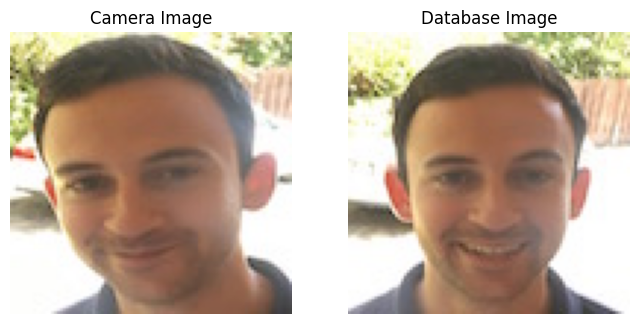

(1, 3, 96, 96)
It's younes, welcome in!


(np.float32(0.22555394), True)

In [51]:
img = cv2.imread("images/camera_0.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  

img2 = cv2.imread("images/younes.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig , arr = plt.subplots(1,2, figsize=(8,4))
arr[0].imshow(img2)
arr[0].set_title("Camera Image")
arr[0].axis('off')
arr[1].imshow(img)
arr[1].set_title("Database Image")
arr[1].axis('off')
plt.show()
verify("images/camera_0.jpg", "younes", database, FRmodel)

(1, 3, 96, 96)
It's not kian, please go away


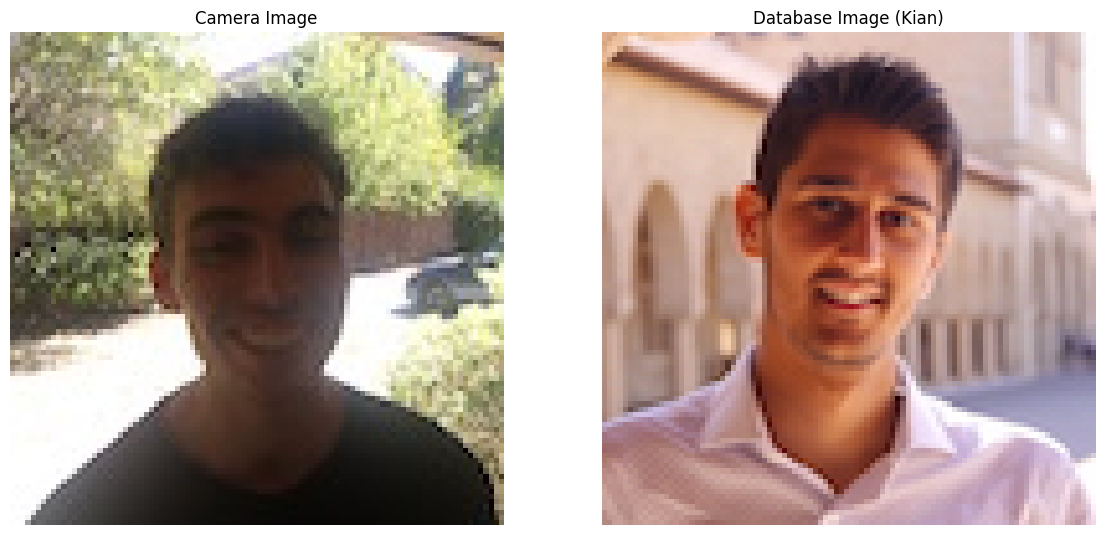

In [ ]:
verify("images/camera_2.jpg", "kian", database, FRmodel)

img = cv2.imread("images/camera_2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img2 = cv2.imread("images/kian.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

fig, arr = plt.subplots(1, 2, figsize=(14, 10))

arr[0].imshow(img)
arr[0].set_title("Camera Image")
arr[1].imshow(img2)
arr[1].set_title("Database Image (Kian)")
arr[0].axis('off')
arr[1].axis('off')

plt.show()


In [ ]:
def who_is_it(image_path, database, model):
    """
    Implements face recognition for the office by finding who is the person on the image_path image.
    
    Arguments:
    image_path -- path to an image
    database -- database containing image encodings along with the name of the person on the image
    model -- your Inception model instance in Keras
    
    Returns:
    min_dist -- the minimum distance between image_path encoding and the encodings from the database
    identity -- string, the name prediction for the person on image_path
    """
    
    
    #Compute the target "encoding" for the image. Use img_to_encoding() see example above.
    encoding = utils.img_to_encoding(image_path, model)
    
    # Find the closest encoding ##
    
    # Initialize "min_dist" to a large value, 
    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current "emb" from the database
        dist = np.linalg.norm(encoding-db_enc)

        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name
        if dist < min_dist:
            min_dist = dist
            identity = name

    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity

(1, 3, 96, 96)
it's younes, the distance is 0.22555394


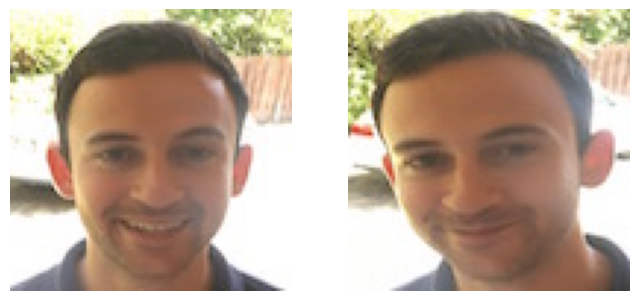

In [50]:

min_dist,id = who_is_it("images/camera_0.jpg", database, FRmodel)

if min_dist < 0.7:
    img = cv2.imread("images/camera_0.jpg")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img2 = cv2.imread(f"images/{id}.jpg")
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    fig , arr = plt.subplots(1,2, figsize=(8,4))
    arr[0].imshow(img)
    arr[0].axis('off')

    arr[1].imshow(img2)
    arr[1].axis('off')
    plt.show()
